<img src='./img/logoline_12000.png' align='right' width='100%'></img>

<br>

# Climatologies and anomalies

### About

This notebook provides you a practical introduction to the topic of how to compute climatologies and anomalies on different spatial and temporal levels.

The notebooks has four sections. The first section [1 - Data preparation](#data_preparation) is mandatory, as it loads and prepares the dataset for the following parts. Sections 2 to 4 are practical examples of how to compute and analyse climatologies and anomalies on different spatial (global and regional) and temporal (annual, monthly and seasonal) levels.

The notebook has the following outline:

* [1 - Data preparation](#data_preparation)
* [2 - Calculation of the annual global mean surface air temperature anomaly](#global_mean)
* [3 - Calculation of the monthly surface air temperature anomaly in Europe](#monthly_europe)
* [4 - Calculation of seasonal variations of near-surface air temperature over the Arctic](#seasonal_arctic)

### Data

This notebook introduces you to the ERA-5 reanalysis monthly averaged data on single levels. The data has the following specifications:

> **Data**: `ERA-5 monthly averaged data on single levels` <br>
> **Temporal coverage**: `Jan 1979 to Dec 2020` <br>
> **Spatial coverage**: `Global` <br>
> **Format**: `NetCDF`<br>
> **Retrieve request**: [CDS API request](./100_climate_data_store_intro.ipynb#era5_monthly)

Get [here](./101_c3s_data_intro.ipynb) more information about climate reanalysis data in general including an overview of they different dataset types.

### Further resources

* [New decade brings reference period change for climate data](https://climate.copernicus.eu/new-decade-reference-period-change-climate-data)
* [2020 closes a decade of exceptional heat](https://public.wmo.int/en/media/news/2020-closes-decade-of-exceptional-heat)
* [Copernicus: 2020 warmest year on record for Europe; globally, 2020 ties with 2016 for warmest year recorded](https://climate.copernicus.eu/2020-warmest-year-record-europe-globally-2020-ties-2016-warmest-year-recorded)

<br>

<hr>

### Load libraries

In [4]:
# CDS API
import cdsapi

# Libraries for working with multi-dimensional arrays
import numpy as np
import xarray as xr
import pandas as pd

# Libraries for plotting and visualising data
import matplotlib.path as mpath
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature

<hr>

## <a id='data_preparation'></a>1. Data preparation

The example below will show you how you can use ERA-5 reanalysis data to analyse climatologies and anomalies of the global near-surface air temperature.

### Load the dataset

The first step is to open the dataset with the function `open_dataset()` of the Python library [xarray](http://xarray.pydata.org/en/stable/). xarray is a Python library that makes the handling of multi-dimensional meteorological and climate data as well as `netCDF` data very efficient. The data file is available under the path: `./data/era5_monthly_t2m.nc`. 

The `open_dataset()` function returns a `xarray.Dataset` object, which can hold one or more `xarray.DataArray` objects, which are aligned on the same dimensions. The loaded `xarray.Dataset` has the following specifications: 
* three dimensions: `latitude`, `longitude` and `time` and
* 1 data variable: `t2m`

In [5]:
file = './data/era5_monthly_t2m.nc'

In [6]:
era5_t2m_ds = xr.open_dataset(file)
era5_t2m_ds

<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 721, time: 504)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2020-12-01
Data variables:
    t2m        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2021-09-16 13:01:32 GMT by grib_to_netcdf-2.20.0: /opt/ecmw...

<br>

Above, you see that the spatial resolution of ERA-5 data is 0.25 degrees for both, latitude and longitude coordinates. What is striking though is that the `longitude` variables are in the range of `[0, 359.75]`. Per default, ECMWF data are on a [0, 360] grid. There are two options to bring the longitude coordinates to a `[-180, 180]` grid. The first option, in case you already have the data downloaded, you can assign values to coordinates with the xarray function `assign_coords()`. The code below shifts your longitude coordinates from `[0, 359.75]` to `[-180, 179.75]`.

The second option is to specify the `area` keyword argument right when you request data with the `CDS API`. The `area` keyword then automatically reprojects the requested data onto a [-180, 180] grid. See an example request with the `area` keyword [here](./100_climate_data_store.ipynb#era5_hourly).

In [7]:
era5_t2m_ds_assigned = era5_t2m_ds.assign_coords(longitude=(((era5_t2m_ds.longitude + 180) % 360) - 180)).sortby('longitude')
era5_t2m_ds_assigned

<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 721, time: 504)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2020-12-01
Data variables:
    t2m        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2021-09-16 13:01:32 GMT by grib_to_netcdf-2.20.0: /opt/ecmw...

<br>

The next step is to load the data variable `t2m` as `xarray.DataArray` object. You can load a data variable from an `xarray.Dataset` by specifying the name of the data variable (`t2m`) in square brackets `[]`. A `xarray.DataArray` object is a labeled, multi-dimensional array, which you can modify and apply operations on. Below, you see additional `attributes` of the data variable, such as `units` and `long_name`.

In [8]:
era5_t2m_da = era5_t2m_ds_assigned['t2m']
era5_t2m_da

<xarray.DataArray 't2m' (time: 504, latitude: 721, longitude: 1440)>
[523272960 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2020-12-01
Attributes:
    units:      K
    long_name:  2 metre temperature

<br>

Above, you see that the ERA-5 temperature data are per default in `Kelvin`, the base unit for temperature in the International System of Units (SI). If you want to convert the values from `Kelvin` to `degrees Celsius`, you have to subtract 273.15.

In [9]:
era5_t2m_da_degc = era5_t2m_da - 273.15
era5_t2m_da_degc

<xarray.DataArray 't2m' (time: 504, latitude: 721, longitude: 1440)>
array([[[-28.442856 , -28.442856 , -28.442856 , ..., -28.442856 ,
         -28.442856 , -28.442856 ],
        [-28.737305 , -28.739075 , -28.739075 , ..., -28.737305 ,
         -28.737305 , -28.737305 ],
        [-28.813126 , -28.813126 , -28.81488  , ..., -28.811356 ,
         -28.811356 , -28.811356 ],
        ...,
        [-31.001251 , -30.997726 , -30.994202 , ..., -31.01007  ,
         -31.006546 , -31.004776 ],
        [-30.581604 , -30.57985  , -30.57808  , ..., -30.586899 ,
         -30.585144 , -30.583374 ],
        [-30.221924 , -30.221924 , -30.221924 , ..., -30.221924 ,
         -30.221924 , -30.221924 ]],

       [[-31.703003 , -31.703003 , -31.703003 , ..., -31.703003 ,
         -31.703003 , -31.703003 ],
        [-32.027435 , -32.02919  , -32.02919  , ..., -32.027435 ,
         -32.027435 , -32.027435 ],
        [-32.18788  , -32.18965  , -32.18965  , ..., -32.186127 ,
         -32.186127 , -32.18788  ],
...
        [-32.894928 , -32.891403 , -32.88611  , ..., -32.907272 ,
         -32.903748 , -32.900208 ],
        [-32.390656 , -32.38713  , -32.38536  , ..., -32.397705 ,
         -32.395935 , -32.39241  ],
        [-32.082092 , -32.082092 , -32.082092 , ..., -32.082092 ,
         -32.082092 , -32.082092 ]],

       [[-20.817017 , -20.817017 , -20.817017 , ..., -20.817017 ,
         -20.817017 , -20.817017 ],
        [-20.859344 , -20.8611   , -20.86287  , ..., -20.85405  ,
         -20.857574 , -20.859344 ],
        [-20.922806 , -20.926346 , -20.92987  , ..., -20.914001 ,
         -20.917526 , -20.921051 ],
        ...,
        [-26.563278 , -26.559753 , -26.554474 , ..., -26.577393 ,
         -26.573868 , -26.568573 ],
        [-26.018448 , -26.016693 , -26.014923 , ..., -26.027267 ,
         -26.021988 , -26.020218 ],
        [-25.695786 , -25.695786 , -25.695786 , ..., -25.695786 ,
         -25.695786 , -25.695786 ]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2020-12-01

<br>

Above, you see that when you convert the data values, the data array's `Attributes` are dropped. However, we want to keep the information provided by the `Attributes` and for this reason, we re-assign the attributes from the `era5_t2m_da` object with the function `assign_attrs()`. Since the unit has changed, we assign a new unit measure to the `units` attribute.

In [8]:
era5_t2m_da_degc = era5_t2m_da_degc.assign_attrs(era5_t2m_da.attrs)
era5_t2m_da_degc.attrs['units'] = '° C'
era5_t2m_da_degc

<xarray.DataArray 't2m' (time: 504, latitude: 721, longitude: 1440)>
array([[[-28.442856 , -28.442856 , -28.442856 , ..., -28.442856 ,
         -28.442856 , -28.442856 ],
        [-28.737305 , -28.739075 , -28.739075 , ..., -28.737305 ,
         -28.737305 , -28.737305 ],
        [-28.813126 , -28.813126 , -28.81488  , ..., -28.811356 ,
         -28.811356 , -28.811356 ],
        ...,
        [-31.001251 , -30.997726 , -30.994202 , ..., -31.01007  ,
         -31.006546 , -31.004776 ],
        [-30.581604 , -30.57985  , -30.57808  , ..., -30.586899 ,
         -30.585144 , -30.583374 ],
        [-30.221924 , -30.221924 , -30.221924 , ..., -30.221924 ,
         -30.221924 , -30.221924 ]],

       [[-31.703003 , -31.703003 , -31.703003 , ..., -31.703003 ,
         -31.703003 , -31.703003 ],
        [-32.027435 , -32.02919  , -32.02919  , ..., -32.027435 ,
         -32.027435 , -32.027435 ],
        [-32.18788  , -32.18965  , -32.18965  , ..., -32.186127 ,
         -32.186127 , -32.18788  ],
...
        [-32.894928 , -32.891403 , -32.88611  , ..., -32.907272 ,
         -32.903748 , -32.900208 ],
        [-32.390656 , -32.38713  , -32.38536  , ..., -32.397705 ,
         -32.395935 , -32.39241  ],
        [-32.082092 , -32.082092 , -32.082092 , ..., -32.082092 ,
         -32.082092 , -32.082092 ]],

       [[-20.817017 , -20.817017 , -20.817017 , ..., -20.817017 ,
         -20.817017 , -20.817017 ],
        [-20.859344 , -20.8611   , -20.86287  , ..., -20.85405  ,
         -20.857574 , -20.859344 ],
        [-20.922806 , -20.926346 , -20.92987  , ..., -20.914001 ,
         -20.917526 , -20.921051 ],
        ...,
        [-26.563278 , -26.559753 , -26.554474 , ..., -26.577393 ,
         -26.573868 , -26.568573 ],
        [-26.018448 , -26.016693 , -26.014923 , ..., -26.027267 ,
         -26.021988 , -26.020218 ],
        [-25.695786 , -25.695786 , -25.695786 , ..., -25.695786 ,
         -25.695786 , -25.695786 ]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2020-12-01
Attributes:
    units:      ° C
    long_name:  2 metre temperature

<br>

Now, let us visualize one time step to get a better idea of the data. xarray offers built-in matplotlib functions that allow you to plot a `DataArray`. With the function `plot()`, you can easily plot e.g. the first time step of the loaded array.

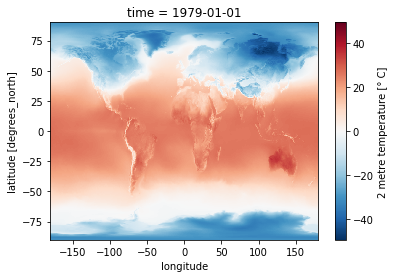

In [9]:
era5_t2m_da_degc[0,:,:].plot()

<br>

An alternative to the built-in xarray plotting functions is to make use of a combination of the plotting libraries [matplotlib](https://matplotlib.org/) and [Cartopy](https://scitools.org.uk/cartopy/docs/latest/). One of Cartopy's key features is its ability to transform array data into different geographic projections. In combination with matplotlib, it is a very powerful way to create high-quality visualisations and animations. 

The code below defines a visualisation function, that combines matplotlib's `pcolormesh()` function with Cartopy's projection capabilites. The function allows to set the following mandatory and optional keyword arguments (kwargs), which give a great flexibility to customize your visualisation:
* `data_array`: xarray.DataArray
* `longitude`, `latitude`: longitude and latitude coordinates
* `projection`: one of [Cartopy's projections](https://scitools.org.uk/cartopy/docs/latest/crs/projections.html)
* `color_scale`: one of [matplotlib's colormaps](https://matplotlib.org/stable/tutorials/colors/colormaps.html)
* `unit`: can be taken from the data's attributes
* `long_name`: can be taken from the data's attributes
* `vmin`, `vmax`: minimum and maximum values for color range
* `set_global` (optional): ability to also show a geographic subset
* `lonmin`, `lonmax`, `latmin`, `latmax` (optional): ability to specify a bounding box



> **Note:** we define a function for the visualization code, as we expect to re-use the same code for many data visualisations. See a full list of defined function [here](./functions.ipynb).

In [14]:
def visualize_pcolormesh(data_array, longitude, latitude, projection, color_scale, unit, long_name, vmin, vmax, 
                         set_global=True, lonmin=-180, lonmax=180, latmin=-90, latmax=90):
    """ 
    Visualizes a xarray.DataArray with matplotlib's pcolormesh function.
    
    Parameters:
        data_array(xarray.DataArray): xarray.DataArray holding the data values
        longitude(xarray.DataArray): xarray.DataArray holding the longitude values
        latitude(xarray.DataArray): xarray.DataArray holding the latitude values
        projection(str): a projection provided by the cartopy library, e.g. ccrs.PlateCarree()
        color_scale(str): string taken from matplotlib's color ramp reference
        unit(str): the unit of the parameter, taken from the NetCDF file if possible
        long_name(str): long name of the parameter, taken from the NetCDF file if possible
        vmin(int): minimum number on visualisation legend
        vmax(int): maximum number on visualisation legend
        set_global(boolean): optional kwarg, default is True
        lonmin,lonmax,latmin,latmax(float): optional kwarg, set geographic extent is set_global kwarg is set to 
                                            False

    """
    fig=plt.figure(figsize=(20, 10))

    ax = plt.axes(projection=projection)
   
    img = plt.pcolormesh(longitude, latitude, data_array, 
                        cmap=plt.get_cmap(color_scale), transform=ccrs.PlateCarree(),
                        vmin=vmin,
                        vmax=vmax,
                        shading='auto')

    ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=1)
    ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=1)

    if (projection==ccrs.PlateCarree()):
        ax.set_extent([lonmin, lonmax, latmin, latmax], projection)
        gl = ax.gridlines(draw_labels=True, linestyle='--')
        gl.top_labels=False
        gl.right_labels=False
        gl.xformatter=LONGITUDE_FORMATTER
        gl.yformatter=LATITUDE_FORMATTER
        gl.xlabel_style={'size':14}
        gl.ylabel_style={'size':14}

    if(set_global):
        ax.set_global()
        ax.gridlines()

    cbar = fig.colorbar(img, ax=ax, orientation='horizontal', fraction=0.04, pad=0.1)
    cbar.set_label(unit, fontsize=16)
    cbar.ax.tick_params(labelsize=14)
    ax.set_title(long_name, fontsize=20, pad=20.0)

    return fig, ax

<br>

The next step is to apply the function `visualize_pcolormesh` to the loaded data. Below, we visualize the first time step (`January 1979`) and use the projection `ccrs.PlateCarree()` to visualize the data. 
Feel free to modify some keywords:
* `color_scale`: we chose `viridis`. Feel free to try out other [colormaps](https://matplotlib.org/stable/tutorials/colors/colormaps.html) offered by matplotlib, e.g. `magma`, `inferno`, `RdBu_r`
* `vmin`, `vmax`: with `xarray.DataArray.min()` and `xarray.DataArray.max()` you can retrieve the minimum and maximum values in order to adjust the color range

(<Figure size 1440x720 with 2 Axes>,
 <cartopy.mpl.geoaxes.GeoAxesSubplot at 0x7ffe38b3eba8>)

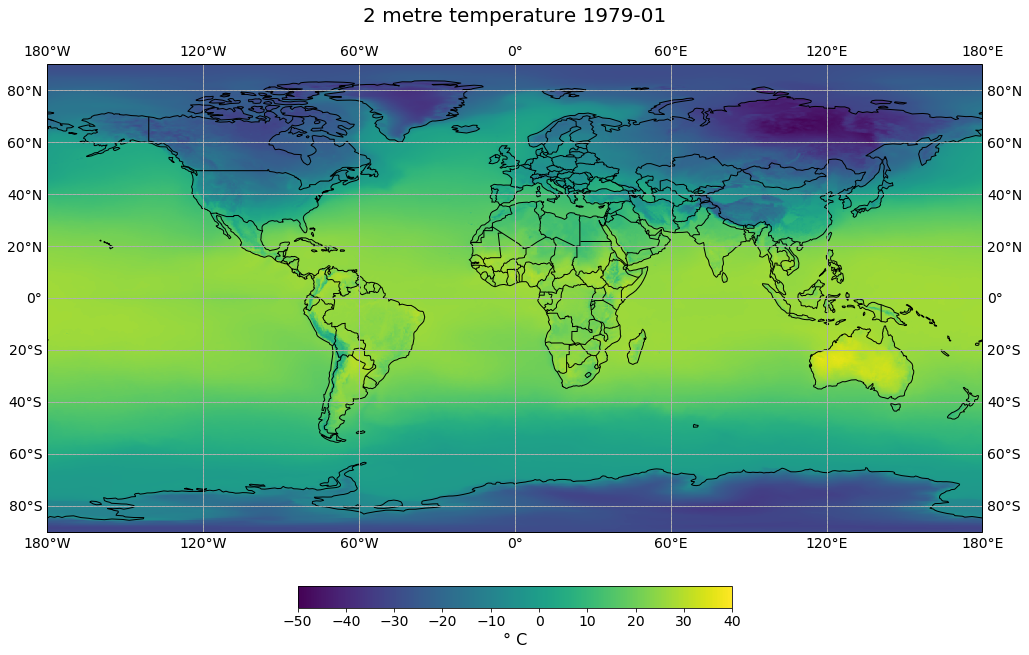

In [11]:
visualize_pcolormesh(data_array = era5_t2m_da_degc[0,:,:],
                    longitude = era5_t2m_da_degc.longitude,
                    latitude = era5_t2m_da_degc.latitude,
                    projection = ccrs.PlateCarree(),
                    color_scale = 'viridis',
                    unit = era5_t2m_da_degc.units,
                    long_name = era5_t2m_da_degc.long_name + ' ' + str(era5_t2m_da_degc[0,:,:].time.data)[0:7] + '\n',
                    vmin = -50,
                    vmax = 40)

<br>

Now, the DataArray object `era5_t2m_da_degc` is in a format which allows us to proceed to analyse temperature anomalies and trends.

## <a id='global_mean'></a> 2. Calculation of the annual global mean surface air temperature anomaly

### Standard reference period and climate normals

Human-induced global warming and natural variations from year to year and even from decade to decade shape the Earth's climate. In order to assess an anomaly of a specific month or year, the World Meteorological Organization (WMO) defines `standard reference periods` in order to create `climate normals`. `Climate normals` can be considered as the typical climate for the period the normals are based on.

Until 2020, the most current and widely used standard reference period was the 30-year period 1981-2010. With the start of 2021 and the move into a new decade, the WMO recommends and the Copernicus Climate Change Service will use the period 1991-2020 climate normal period as the main reference period.


First, let us calculate the global near-surface air temperature climate normal for the reference period 1981-2010. For this, we first have to create for each year the average near-surface air temperature. You can use the xarray function `groupby()` to first group the data by year (specify `time.year`) and then to create the average of each year with the function `mean()`. The resulting object contains for each year from 1979 to 2020 the average annual global mean surface air temperature.

<br>

**Note**: the `groupby()` operation dropped again the `Attributes` from the DataArray. 

In [74]:
yearly_mean = era5_t2m_da_degc.groupby('time.year').mean()
yearly_mean

<xarray.DataArray 't2m' (year: 42, latitude: 721, longitude: 1440)>
array([[[-15.298064 , -15.298064 , -15.298064 , ..., -15.298064 ,
         -15.298064 , -15.298064 ],
        [-15.436477 , -15.436917 , -15.437214 , ..., -15.4355955,
         -15.435741 , -15.436181 ],
        [-15.452344 , -15.453228 , -15.4538145, ..., -15.449847 ,
         -15.450582 , -15.451169 ],
        ...,
        [-45.708084 , -45.703968 , -45.70029  , ..., -45.71881  ,
         -45.714993 , -45.71146  ],
        [-45.55528  , -45.55292  , -45.55131  , ..., -45.56012  ,
         -45.558804 , -45.557037 ],
        [-45.233643 , -45.233643 , -45.233643 , ..., -45.233643 ,
         -45.233643 , -45.233643 ]],

       [[-14.361809 , -14.361809 , -14.361809 , ..., -14.361809 ,
         -14.361809 , -14.361809 ],
        [-14.552819 , -14.552966 , -14.553555 , ..., -14.551941 ,
         -14.552382 , -14.552528 ],
        [-14.597046 , -14.597487 , -14.597782 , ..., -14.595573 ,
         -14.596016 , -14.596313 ],
...
        [-45.42098  , -45.417892 , -45.414516 , ..., -45.431263 ,
         -45.42803  , -45.42435  ],
        [-45.306072 , -45.304317 , -45.302994 , ..., -45.311214 ,
         -45.309452 , -45.307697 ],
        [-44.965336 , -44.965336 , -44.965336 , ..., -44.965336 ,
         -44.965336 , -44.965336 ]],

       [[-12.439185 , -12.439185 , -12.439185 , ..., -12.439185 ,
         -12.439185 , -12.439185 ],
        [-12.433015 , -12.43419  , -12.435216 , ..., -12.430664 ,
         -12.431987 , -12.432575 ],
        [-12.39907  , -12.400544 , -12.402013 , ..., -12.394223 ,
         -12.395253 , -12.397018 ],
        ...,
        [-45.217037 , -45.213947 , -45.21101  , ..., -45.22644  ,
         -45.223938 , -45.22041  ],
        [-45.08435  , -45.082886 , -45.08127  , ..., -45.089054 ,
         -45.087437 , -45.085674 ],
        [-44.755672 , -44.755672 , -44.755672 , ..., -44.755672 ,
         -44.755672 , -44.755672 ]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * year       (year) int64 1979 1980 1981 1982 1983 ... 2017 2018 2019 2020

<br>

From the data array object above, we can then filter the years of the reference period with the function `where()`. Inside the function, you can filter on the data dimensions. In the example below, you want to filter all years after 1980 and before 2011.

In [13]:
era5_t2m_ref = yearly_mean.where((yearly_mean.year > 1980) & (yearly_mean.year < 2011), drop=True)
era5_t2m_ref

<xarray.DataArray 't2m' (year: 30, latitude: 721, longitude: 1440)>
array([[[-13.576743 , -13.576743 , -13.576743 , ..., -13.576743 ,
         -13.576743 , -13.576743 ],
        [-13.868111 , -13.868259 , -13.86782  , ..., -13.869433 ,
         -13.869287 , -13.868698 ],
        [-14.000202 , -13.99932  , -13.9987335, ..., -14.001819 ,
         -14.001084 , -14.000497 ],
        ...,
        [-44.938156 , -44.935215 , -44.931396 , ..., -44.947117 ,
         -44.944477 , -44.941387 ],
        [-44.811646 , -44.80988  , -44.808563 , ..., -44.816788 ,
         -44.81503  , -44.813847 ],
        [-44.518814 , -44.518814 , -44.518814 , ..., -44.518814 ,
         -44.518814 , -44.518814 ]],

       [[-13.987714 , -13.987714 , -13.987714 , ..., -13.987714 ,
         -13.987714 , -13.987714 ],
        [-14.2787895, -14.278937 , -14.278937 , ..., -14.278202 ,
         -14.278054 , -14.278496 ],
        [-14.387665 , -14.3879595, -14.388252 , ..., -14.38605  ,
         -14.386344 , -14.387223 ],
...
        [-45.60391  , -45.600384 , -45.59671  , ..., -45.613903 ,
         -45.610523 , -45.607437 ],
        [-45.36191  , -45.360443 , -45.358532 , ..., -45.36676  ,
         -45.365147 , -45.363678 ],
        [-44.95579  , -44.95579  , -44.95579  , ..., -44.95579  ,
         -44.95579  , -44.95579  ]],

       [[-14.483764 , -14.483764 , -14.483764 , ..., -14.483764 ,
         -14.483764 , -14.483764 ],
        [-14.449229 , -14.44923  , -14.449231 , ..., -14.449523 ,
         -14.449229 , -14.449229 ],
        [-14.414557 , -14.414115 , -14.413818 , ..., -14.413822 ,
         -14.414266 , -14.413968 ],
        ...,
        [-45.959347 , -45.956547 , -45.95332  , ..., -45.96933  ,
         -45.965954 , -45.96287  ],
        [-45.81447  , -45.81285  , -45.811085 , ..., -45.81917  ,
         -45.817844 , -45.81638  ],
        [-45.48225  , -45.48225  , -45.48225  , ..., -45.48225  ,
         -45.48225  , -45.48225  ]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * year       (year) int64 1981 1982 1983 1984 1985 ... 2007 2008 2009 2010

<br>

In a last step, we want to create the average near-surface air temperature for the reference period. We can do this by applying the function `mean()` and specify the dimension `year` as the dimension to be averaged. The resulting data array remains with two dimensions, latitude and longitude.

In [14]:
era5_t2m_ref_mean = era5_t2m_ref.mean(dim="year")
era5_t2m_ref_mean

<xarray.DataArray 't2m' (latitude: 721, longitude: 1440)>
array([[-14.215117 , -14.215117 , -14.215117 , ..., -14.215117 ,
        -14.215117 , -14.215117 ],
       [-14.29575  , -14.296027 , -14.296268 , ..., -14.295077 ,
        -14.295232 , -14.295549 ],
       [-14.317957 , -14.318407 , -14.318906 , ..., -14.316492 ,
        -14.3169565, -14.3174305],
       ...,
       [-45.923943 , -45.920464 , -45.916954 , ..., -45.93445  ,
        -45.93093  , -45.92744  ],
       [-45.787704 , -45.78594  , -45.784245 , ..., -45.792908 ,
        -45.791145 , -45.789494 ],
       [-45.456154 , -45.456154 , -45.456154 , ..., -45.456154 ,
        -45.456154 , -45.456154 ]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0

<br>

In a next step, let us visualize the average near-surface air temperature for the reference period 1981-2010. As the attributes have dropped again after the `groupby()` operation, we might want to re-assign them with the function `assign_attrs()`. This time though, we can alter the `long_name` attribute and specify the operation conducted on the data. 


In [15]:
era5_t2m_ref_mean = era5_t2m_ref_mean.assign_attrs(era5_t2m_da_degc.attrs)
era5_t2m_ref_mean.attrs['long_name'] = 'Average near-surface air temperature for reference period 1981-2010'
era5_t2m_ref_mean

<xarray.DataArray 't2m' (latitude: 721, longitude: 1440)>
array([[-14.215117 , -14.215117 , -14.215117 , ..., -14.215117 ,
        -14.215117 , -14.215117 ],
       [-14.29575  , -14.296027 , -14.296268 , ..., -14.295077 ,
        -14.295232 , -14.295549 ],
       [-14.317957 , -14.318407 , -14.318906 , ..., -14.316492 ,
        -14.3169565, -14.3174305],
       ...,
       [-45.923943 , -45.920464 , -45.916954 , ..., -45.93445  ,
        -45.93093  , -45.92744  ],
       [-45.787704 , -45.78594  , -45.784245 , ..., -45.792908 ,
        -45.791145 , -45.789494 ],
       [-45.456154 , -45.456154 , -45.456154 , ..., -45.456154 ,
        -45.456154 , -45.456154 ]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
Attributes:
    units:      ° C
    long_name:  Average near-surface air temperature for reference period 198...

<br>

Now, we can use the function `visualize_pcolormesh()` to visualize the data array object `era5_t2m_ref_mean`.

(<Figure size 1440x720 with 2 Axes>,
 <cartopy.mpl.geoaxes.GeoAxesSubplot at 0x7ffe2ecae550>)

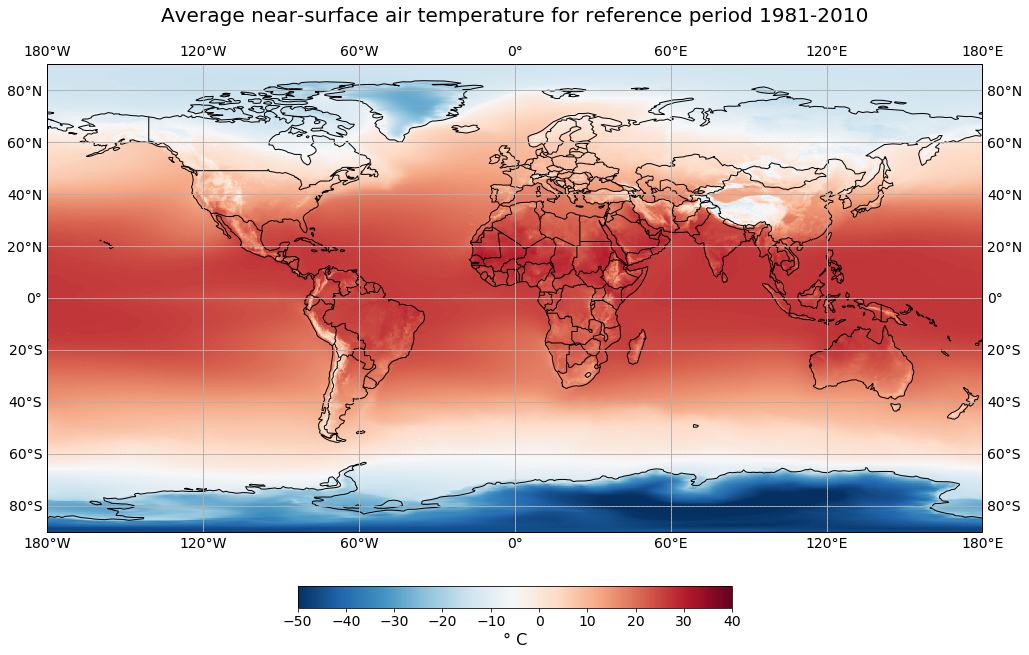

In [16]:
visualize_pcolormesh(data_array = era5_t2m_ref_mean,
                    longitude = era5_t2m_ref_mean.longitude,
                    latitude = era5_t2m_ref_mean.latitude,
                    projection = ccrs.PlateCarree(),
                    color_scale = 'RdBu_r',
                    unit = era5_t2m_ref_mean.units,
                    long_name = era5_t2m_ref_mean.long_name + '\n',
                    vmin = -50,
                    vmax = 40)

<br>

### Anomalies

The next step is now to calculate the anomaly of a specific year from the reference value. The term anomaly refers to the deviation of a value from the long-term average. A positive anomaly indicates that the average temperature of this particular year was warmer than the reference value, while a negative anomaly indicates that the average temperature for this year was cooler than the reference value.

Globally, 2016 and 2020 were so far the hottest years on record. Let us calculate the near-surface air temperature anomaly for the year 2016. In a first step, we select the average near-surface temperature values for the year 2016 from the xarray.DataArray object `yearly_mean`. With the xarray function `sel()`, you can select a data array based on coordinate labels. The coordinate label of interest is `year=2016`.

In [17]:
era5_t2m_2016 = yearly_mean.sel(year=2016)
era5_t2m_2016

<xarray.DataArray 't2m' (latitude: 721, longitude: 1440)>
array([[-11.07256 , -11.07256 , -11.07256 , ..., -11.07256 , -11.07256 ,
        -11.07256 ],
       [-11.12693 , -11.127369, -11.128104, ..., -11.126485, -11.126633,
        -11.127075],
       [-11.153811, -11.1544  , -11.154988, ..., -11.152199, -11.152936,
        -11.15352 ],
       ...,
       [-45.929073, -45.926136, -45.922756, ..., -45.938324, -45.934956,
        -45.932163],
       [-45.872356, -45.871037, -45.869415, ..., -45.87749 , -45.875732,
        -45.873974],
       [-45.58995 , -45.58995 , -45.58995 , ..., -45.58995 , -45.58995 ,
        -45.58995 ]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
    year       int64 2016

<br>

Next, we calculate the near-surface air temperature anomaly for 2016 by subtracting the reference near-surface air temperature values (data array `era5_t2m_ref_mean`) from the average near-surface air temperature from 2016.

In [18]:
era5_t2m_anomaly_2016 = era5_t2m_2016 - era5_t2m_ref_mean
era5_t2m_anomaly_2016

<xarray.DataArray 't2m' (latitude: 721, longitude: 1440)>
array([[ 3.1425571 ,  3.1425571 ,  3.1425571 , ...,  3.1425571 ,
         3.1425571 ,  3.1425571 ],
       [ 3.1688194 ,  3.1686583 ,  3.1681643 , ...,  3.1685925 ,
         3.1685991 ,  3.1684742 ],
       [ 3.1641455 ,  3.1640072 ,  3.1639175 , ...,  3.1642933 ,
         3.1640205 ,  3.1639109 ],
       ...,
       [-0.00513077, -0.00567245, -0.00580215, ..., -0.00387573,
        -0.00402451, -0.0047226 ],
       [-0.08465195, -0.08509827, -0.08517075, ..., -0.08458328,
        -0.0845871 , -0.08448029],
       [-0.13379669, -0.13379669, -0.13379669, ..., -0.13379669,
        -0.13379669, -0.13379669]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
    year       int64 2016

<br>

Since we calculated now the anomalies and modified again our data array, the attributes dropped again. Let us take the attributes take forward and adjust as well the `long_name` attribute to specify that the data array reflects the near-surface air temperature anomalies.

In [19]:
era5_t2m_anomaly_2016 = era5_t2m_anomaly_2016.assign_attrs(era5_t2m_ref_mean.attrs)
era5_t2m_anomaly_2016.attrs['long_name'] = 'Global near-surface air temperature anomaly for 2016 (based on reference period 1981-2010)'
era5_t2m_anomaly_2016

<xarray.DataArray 't2m' (latitude: 721, longitude: 1440)>
array([[ 3.1425571 ,  3.1425571 ,  3.1425571 , ...,  3.1425571 ,
         3.1425571 ,  3.1425571 ],
       [ 3.1688194 ,  3.1686583 ,  3.1681643 , ...,  3.1685925 ,
         3.1685991 ,  3.1684742 ],
       [ 3.1641455 ,  3.1640072 ,  3.1639175 , ...,  3.1642933 ,
         3.1640205 ,  3.1639109 ],
       ...,
       [-0.00513077, -0.00567245, -0.00580215, ..., -0.00387573,
        -0.00402451, -0.0047226 ],
       [-0.08465195, -0.08509827, -0.08517075, ..., -0.08458328,
        -0.0845871 , -0.08448029],
       [-0.13379669, -0.13379669, -0.13379669, ..., -0.13379669,
        -0.13379669, -0.13379669]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
    year       int64 2016
Attributes:
    units:      ° C
    long_name:  Global near-surface air temperature anomaly for 2016 (based o...

<br>

Now, let us visualize the global near-surface air temperature anomaly for 2016. This allow us to see directly regions which were warmer or cooler compared to the reference period. Let us use the function `visualize_pcolormesh()` for the visualisation again. This time, we have to adjust the `vmin` and `vmax` arguments, as we represent anomalies in degrees Celsius.

(<Figure size 1440x720 with 2 Axes>,
 <cartopy.mpl.geoaxes.GeoAxesSubplot at 0x7ffc93a9c1d0>)

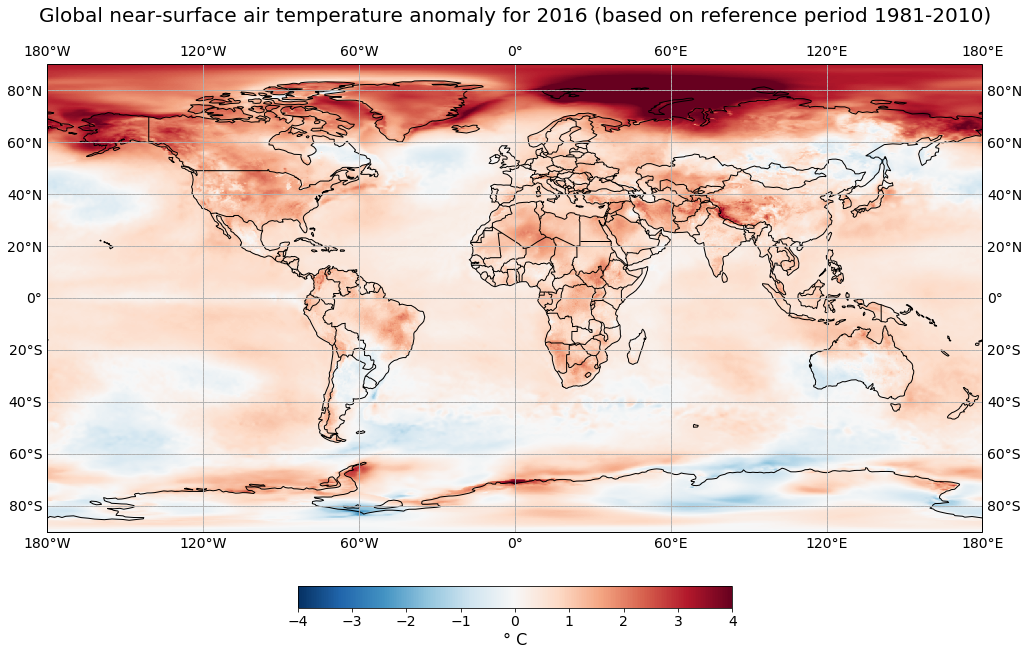

In [20]:
visualize_pcolormesh(data_array = era5_t2m_anomaly_2016,
                    longitude = era5_t2m_anomaly_2016.longitude,
                    latitude = era5_t2m_anomaly_2016.latitude,
                    projection = ccrs.PlateCarree(),
                    color_scale = 'RdBu_r',
                    unit = era5_t2m_anomaly_2016.units,
                    long_name = era5_t2m_anomaly_2016.long_name + '\n',
                    vmin = -4,
                    vmax = 4)

<br>

As a last step in analysing global near-surface temperature anomalies, let us compute global annual anomalies for each year from 1979 to 2020 and visualize it as a bar plot. This helps us to better understand which year since 1979 was warmer compared to the reference period and which was in average cooler.

To do this, the first step is to compute an overall average for the global near-surface air temperature for the reference period. You can compute the overall average of the data array object `era5_t2m_ref_mean` by applying the function `mean()` to the two dimensions `['longitude', 'latitude]`. The result is one single value with the global average near-surface temperature for the period 1981 to 2010. 

In [21]:
t2m_ref_global = era5_t2m_ref_mean.mean(["longitude", "latitude"])
t2m_ref_global


<xarray.DataArray 't2m' ()>
array(5.208174, dtype=float32)

<br>

The same process as above is repeated in order to compute the global average near-surface temperature for each year from 1979 to 2020. You average both dimensions of the data array object `yearly_mean`. The result is a one-dimensional xarray.DataArray object with 42 entires, containing the overall global near-surface air temperature value for each year.

In [22]:
t2m_annual_mean_global = yearly_mean.mean(["longitude", "latitude"])
t2m_annual_mean_global

<xarray.DataArray 't2m' (year: 42)>
array([4.8291273, 5.152675 , 5.275028 , 4.9425335, 5.099182 , 5.0244045,
       4.898449 , 4.9289103, 4.92868  , 5.1549788, 4.997951 , 5.3696356,
       5.287527 , 4.968616 , 4.9112325, 4.9139094, 5.2224083, 5.1542225,
       5.150779 , 5.300178 , 5.1046066, 5.1324697, 5.3003383, 5.472924 ,
       5.3612485, 5.2489214, 5.607038 , 5.508251 , 5.5752773, 5.3528595,
       5.50441  , 5.5482802, 5.5614905, 5.5608816, 5.5374665, 5.5795393,
       5.6449714, 6.015099 , 5.8603415, 5.869142 , 5.9012384, 6.010359 ],
      dtype=float32)
Coordinates:
  * year     (year) int64 1979 1980 1981 1982 1983 ... 2016 2017 2018 2019 2020

<br>

Now, we can compute the annual anomalies of each year by subtracting the average air temperature value for the reference period from the average value for each year. The result is a xarray.DataArray with 42 entries, containing the anomaly of global near-surface air temperature for each year from 1979 to 2020.

In [23]:
t2m_anomalies_global = t2m_annual_mean_global - t2m_ref_global
t2m_anomalies_global

<xarray.DataArray 't2m' (year: 42)>
array([-0.37904692, -0.05549908,  0.066854  , -0.26564074, -0.1089921 ,
       -0.1837697 , -0.30972528, -0.27926397, -0.2794943 , -0.05319548,
       -0.2102232 ,  0.16146135,  0.07935286, -0.23955822, -0.29694176,
       -0.2942648 ,  0.01423407, -0.05395174, -0.05739546,  0.09200382,
       -0.1035676 , -0.07570457,  0.09216404,  0.26475   ,  0.15307426,
        0.04074717,  0.3988638 ,  0.30007696,  0.3671031 ,  0.14468527,
        0.29623556,  0.340106  ,  0.3533163 ,  0.3527074 ,  0.3292923 ,
        0.37136507,  0.43679714,  0.8069248 ,  0.6521673 ,  0.6609678 ,
        0.6930642 ,  0.8021846 ], dtype=float32)
Coordinates:
  * year     (year) int64 1979 1980 1981 1982 1983 ... 2016 2017 2018 2019 2020

<br>

In a last step, we want to visualize the annual global anomalies as bar plot. We want to apply the color blue for years that are cooler than the reference period (negative anomalies) and the color red for years that are warmer than the reference period. For this, the next step is to convert the `xarray.DataArray` object into a `pandas.DataFrame` with the function `to_dataframe()`. Let us add an additional columns called `positive`, indicating with a boolean value whether the air temperature anomaly is positive (`True`) or negative (`False`). The result is a data frame with 42 rows (one row per year) and two columns (`t2m`, `positive`).

In [25]:
df = t2m_anomalies_global.to_dataframe()
df['positive'] = df['t2m'] > 0
df

,t2m,positive
year,,
1979,-0.379047,False
1980,-0.055499,False
1981,0.066854,True
1982,-0.265641,False
1983,-0.108992,False
1984,-0.183770,False
1985,-0.309725,False
1986,-0.279264,False
1987,-0.279494,False


<br>

The `pandas.DataFrame` can then be visualized with the pandas built-in `plot()` function. You can customize the plot with the following keyword arguments:
* `figsize`: Define the size of the plot
* `kind`: Type of plot, e.g. `line`, `bar`, etc.
* `color`: color of the bars. With `df.positive.map()`, the colum `positive` is used to distinguish between bars that shall be colored in blue and bar that shall be colored in red
* `fontsize`: fontsize for x- and yticks
* `xlabel`, `ylabel`: Labels for x and y axes
* `title`: Title of the plot

See [here](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.html) a full list of possible keyword arguments.



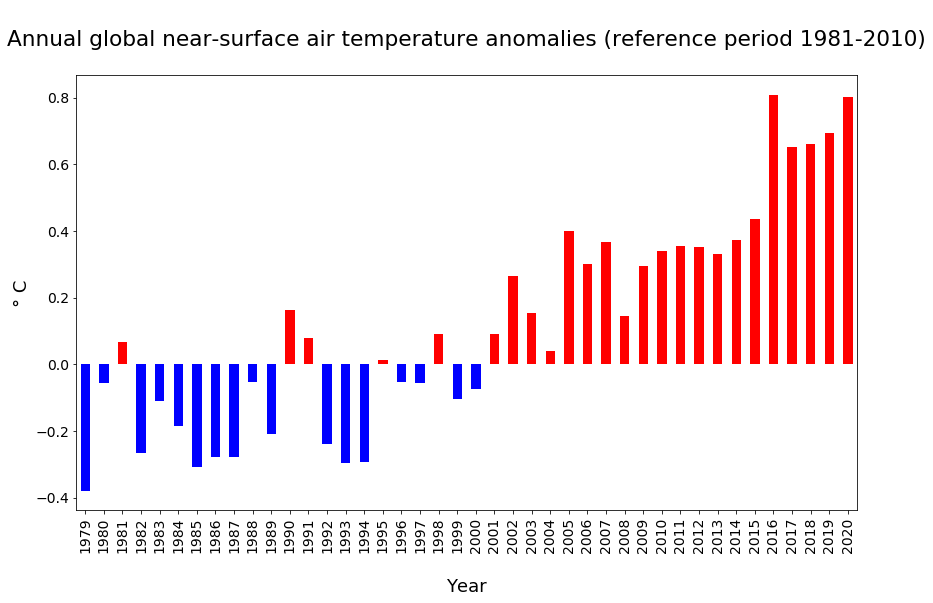

In [40]:
plt.rcParams.update({'font.size': 18}) # must set in top
df['t2m'].plot(
    figsize=(14,8),
    kind='bar',
    color=df.positive.map({True: 'red', False: 'blue'}),
    fontsize=14,
    xlabel='\nYear',
    ylabel='° C',
    title='\nAnnual global near-surface air temperature anomalies (reference period 1981-2010)\n',
    )


<br>

In the plot above, you see that since 2001, each year the global near-surface air temperature was warmer than the reference mean from 1981-2010. You can also see very well, that 2016 and 2020 were so far the hottest years on record. Read more about the analysis of the surface air temperature in 2020 [here](https://climate.copernicus.eu/2020-warmest-year-record-europe-globally-2020-ties-2016-warmest-year-recorded). 

You can also repeat the analysis steps and choose as reference period 1991-2020. What differences can you observe?

<br>

<hr>

## <a id='monthly_europe'></a>3. Calculation of the monthly surface air temperature anomaly in Europe

The following example will show you how to calculate near-surface air temperature anomalies for a specific month in Europe. 

**Note:** The example starts with the loaded data array `era5_t2m_da_degc`, which has been prepared under [1. Data preparation](#data_preparation). If you have not loaded the data array object, please go to the first step and follow the step-by-step guide there.

As a reminder, let us have a look at the data array `era5_t2m_da_degc`. You see below that the data array has three dimensions (`time`, `latitude` and `longitude`) and represents the global monthly averaged near-surface air temperature in degrees Celsius from January 1979 to December 2020.

In [42]:
era5_t2m_da_degc

<xarray.DataArray 't2m' (time: 504, latitude: 721, longitude: 1440)>
array([[[-28.442856 , -28.442856 , -28.442856 , ..., -28.442856 ,
         -28.442856 , -28.442856 ],
        [-28.737305 , -28.739075 , -28.739075 , ..., -28.737305 ,
         -28.737305 , -28.737305 ],
        [-28.813126 , -28.813126 , -28.81488  , ..., -28.811356 ,
         -28.811356 , -28.811356 ],
        ...,
        [-31.001251 , -30.997726 , -30.994202 , ..., -31.01007  ,
         -31.006546 , -31.004776 ],
        [-30.581604 , -30.57985  , -30.57808  , ..., -30.586899 ,
         -30.585144 , -30.583374 ],
        [-30.221924 , -30.221924 , -30.221924 , ..., -30.221924 ,
         -30.221924 , -30.221924 ]],

       [[-31.703003 , -31.703003 , -31.703003 , ..., -31.703003 ,
         -31.703003 , -31.703003 ],
        [-32.027435 , -32.02919  , -32.02919  , ..., -32.027435 ,
         -32.027435 , -32.027435 ],
        [-32.18788  , -32.18965  , -32.18965  , ..., -32.186127 ,
         -32.186127 , -32.18788  ],
...
        [-32.894928 , -32.891403 , -32.88611  , ..., -32.907272 ,
         -32.903748 , -32.900208 ],
        [-32.390656 , -32.38713  , -32.38536  , ..., -32.397705 ,
         -32.395935 , -32.39241  ],
        [-32.082092 , -32.082092 , -32.082092 , ..., -32.082092 ,
         -32.082092 , -32.082092 ]],

       [[-20.817017 , -20.817017 , -20.817017 , ..., -20.817017 ,
         -20.817017 , -20.817017 ],
        [-20.859344 , -20.8611   , -20.86287  , ..., -20.85405  ,
         -20.857574 , -20.859344 ],
        [-20.922806 , -20.926346 , -20.92987  , ..., -20.914001 ,
         -20.917526 , -20.921051 ],
        ...,
        [-26.563278 , -26.559753 , -26.554474 , ..., -26.577393 ,
         -26.573868 , -26.568573 ],
        [-26.018448 , -26.016693 , -26.014923 , ..., -26.027267 ,
         -26.021988 , -26.020218 ],
        [-25.695786 , -25.695786 , -25.695786 , ..., -25.695786 ,
         -25.695786 , -25.695786 ]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2020-12-01
Attributes:
    units:      ° C
    long_name:  2 metre temperature

<br>

### Create a geographical subset

Let us first create a geographical subset for Europe. First, we define the latitude and longitude minimum and maximum values, which we use in a second step to subset the data array `era5_t2m_da_degc`. You can subset / filter an xarray.DatArray based on a condition with the function `where()`. We also set the keyword argument `drop=True`, as we want to remove the other data points outside Europe.

The resulting data array `era5_t2m_eur_subset` has still three dimensions, but the dimensions `latitude` and `longitude` have now reduced to 99 (latitude) and 159 (longitude) grid points respectively.

In [46]:
latmin = 35.
latmax = 60.
lonmin = -10.
lonmax = 30.

latitude = era5_t2m_da_degc.latitude
longitude=era5_t2m_da_degc.longitude


era5_t2m_eur_subset = era5_t2m_da_degc.where((latitude < latmax) &
                                            (latitude > latmin) &
                                            (longitude < lonmax) &
                                            (longitude > lonmin), 
                                             drop=True)
era5_t2m_eur_subset

<xarray.DataArray 't2m' (time: 504, latitude: 99, longitude: 159)>
array([[[  4.622406 ,   4.6153564,   4.5765686, ...,  -9.93457  ,
         -10.042114 , -10.098541 ],
        [  4.715851 ,   4.705261 ,   4.6682434, ..., -10.357727 ,
         -10.474091 , -10.572845 ],
        [  4.8339844,   4.828705 ,   4.7951965, ..., -10.1285095,
         -10.317169 , -10.417694 ],
        ...,
        [ 15.5260315,  15.559509 ,  15.601837 , ...,  13.993805 ,
          14.184235 ,  14.26886  ],
        [ 15.682953 ,  15.704102 ,  15.73584  , ...,  13.815704 ,
          13.868622 ,  13.926788 ],
        [ 15.785217 ,  15.816956 ,  15.862793 , ...,  14.08548  ,
          14.171875 ,  14.231842 ]],

       [[  5.3611755,   5.315338 ,   5.2536316, ..., -10.955444 ,
         -11.001312 , -11.013641 ],
        [  5.4334717,   5.3876343,   5.317108 , ..., -11.241089 ,
         -11.288696 , -11.297516 ],
        [  5.5269165,   5.4757996,   5.4052734, ..., -10.909607 ,
         -11.066528 , -11.110626 ],
...
        [ 18.46878  ,  18.537567 ,  18.65039  , ...,  20.32898  ,
          20.540558 ,  20.651642 ],
        [ 18.592224 ,  18.65921  ,  18.766785 , ...,  19.934021 ,
          20.043335 ,  20.12973  ],
        [ 18.749146 ,  18.83554  ,  18.946625 , ...,  19.932251 ,
          20.099762 ,  20.221405 ]],

       [[  7.276001 ,   7.2989197,   7.3006897, ...,  -1.370697 ,
          -1.4888306,  -1.5752258],
        [  7.348297 ,   7.3677063,   7.3835754, ...,  -1.8397217,
          -1.9543152,  -2.0266113],
        [  7.431183 ,   7.457611 ,   7.4787903, ...,  -1.5523071,
          -1.7462769,  -1.8291321],
        ...,
        [ 16.65799  ,  16.615662 ,  16.589233 , ...,  17.500793 ,
          17.73529  ,  17.864014 ],
        [ 16.802582 ,  16.756744 ,  16.733795 , ...,  17.223969 ,
          17.313904 ,  17.421448 ],
        [ 16.957733 ,  16.933044 ,  16.927765 , ...,  17.488464 ,
          17.625977 ,  17.7406   ]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -9.75 -9.5 -9.25 -9.0 ... 29.25 29.5 29.75
  * latitude   (latitude) float32 59.75 59.5 59.25 59.0 ... 35.75 35.5 35.25
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2020-12-01
Attributes:
    units:      ° C
    long_name:  2 metre temperature

<br>

A quick look at the first time step of the subsetted data array with the xarray built-in function `plot()` indicates that the subset represents Europe. The coastal outline of Europe is well observable.

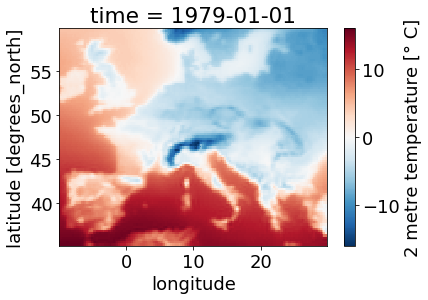

In [49]:
era5_t2m_eur_subset[0,:,:].plot()

<br>

### Calculate monthly climatologies and anomalies based on the reference period 1991 to 2020

This time, let us calculate `monthly climatologies` based on the reference period 1991 to 2020. A monthly climatology has a mean near-surface air temperature value for each month over a period of 30 years. The first step is to create a temporal subset and select the data from January 1991 to December 2020. You can use the function `sel()`, which allows you to filter based on dimension labels. The cell below selects the temperature values for the reference period 1991 to 2020.

The time dimension entries of the resulting data array `era5_t2m_eur_ref` reduced from previously 504 to 360 entries.

In [75]:
era5_t2m_eur_ref = era5_t2m_eur_subset.sel(time=slice('1991-01-01', '2020-12-01'))
era5_t2m_eur_ref

<xarray.DataArray 't2m' (time: 360, latitude: 99, longitude: 159)>
array([[[ 6.780548 ,  6.7734985,  6.73999  , ..., -4.7313538,
         -4.8530273, -4.9200134],
        [ 6.8158264,  6.807007 ,  6.7717285, ..., -5.1245728,
         -5.247986 , -5.3132324],
        [ 6.8722534,  6.863434 ,  6.8316956, ..., -4.817749 ,
         -4.9888   , -5.0628357],
        ...,
        [14.723755 , 14.725525 , 14.7361145, ..., 14.127808 ,
         14.293549 , 14.325287 ],
        [14.850708 , 14.840118 , 14.82251  , ..., 13.8897705,
         13.90564  , 13.89505  ],
        [14.940643 , 14.924774 , 14.919464 , ..., 14.073151 ,
         14.157776 , 14.217712 ]],

       [[ 6.3679504,  6.3538513,  6.3150635, ..., -6.4839783,
         -6.5739136, -6.623291 ],
        [ 6.37677  ,  6.360901 ,  6.3132935, ..., -6.5739136,
         -6.6691284, -6.7502136],
        [ 6.431427 ,  6.396179 ,  6.348572 , ..., -6.1824646,
         -6.3217773, -6.395813 ],
...
        [18.46878  , 18.537567 , 18.65039  , ..., 20.32898  ,
         20.540558 , 20.651642 ],
        [18.592224 , 18.65921  , 18.766785 , ..., 19.934021 ,
         20.043335 , 20.12973  ],
        [18.749146 , 18.83554  , 18.946625 , ..., 19.932251 ,
         20.099762 , 20.221405 ]],

       [[ 7.276001 ,  7.2989197,  7.3006897, ..., -1.370697 ,
         -1.4888306, -1.5752258],
        [ 7.348297 ,  7.3677063,  7.3835754, ..., -1.8397217,
         -1.9543152, -2.0266113],
        [ 7.431183 ,  7.457611 ,  7.4787903, ..., -1.5523071,
         -1.7462769, -1.8291321],
        ...,
        [16.65799  , 16.615662 , 16.589233 , ..., 17.500793 ,
         17.73529  , 17.864014 ],
        [16.802582 , 16.756744 , 16.733795 , ..., 17.223969 ,
         17.313904 , 17.421448 ],
        [16.957733 , 16.933044 , 16.927765 , ..., 17.488464 ,
         17.625977 , 17.7406   ]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -9.75 -9.5 -9.25 -9.0 ... 29.25 29.5 29.75
  * latitude   (latitude) float32 59.75 59.5 59.25 59.0 ... 35.75 35.5 35.25
  * time       (time) datetime64[ns] 1991-01-01 1991-02-01 ... 2020-12-01
Attributes:
    units:      ° C
    long_name:  2 metre temperature

<br>

The next step is to create the `monthly climatology`. On the data array `era5_t2m_eur_ref`, you apply the function `groupby()` where you first group the data array based on monthly information. Afterwards, based on the defined groups, you build the average for each group (month).

The resulting data array `monthly_mean` is the monthly climatology for air temperature in Europe based on the reference period 1991 to 2020.

In [76]:
monthly_mean = era5_t2m_eur_ref.groupby('time.month').mean()
monthly_mean

<xarray.DataArray 't2m' (month: 12, latitude: 99, longitude: 159)>
array([[[ 7.021465  ,  7.021817  ,  7.0012484 , ..., -5.4214835 ,
         -5.5269775 , -5.578521  ],
        [ 7.115441  ,  7.11421   ,  7.096107  , ..., -5.907068  ,
         -6.015094  , -6.0785055 ],
        [ 7.226292  ,  7.224114  ,  7.211477  , ..., -5.5993304 ,
         -5.791048  , -5.8728595 ],
        ...,
        [15.274347  , 15.262299  , 15.2586565 , ..., 14.287368  ,
         14.45141   , 14.504534  ],
        [15.385251  , 15.364622  , 15.350577  , ..., 14.069731  ,
         14.101116  , 14.122275  ],
        [15.465245  , 15.451902  , 15.449843  , ..., 14.265857  ,
         14.349548  , 14.407853  ]],

       [[ 6.6641216 ,  6.6608915 ,  6.6402006 , ..., -5.7107058 ,
         -5.7821136 , -5.8001    ],
        [ 6.7578673 ,  6.7541056 ,  6.735182  , ..., -6.063227  ,
         -6.141572  , -6.191706  ],
        [ 6.8693004 ,  6.865072  ,  6.8488526 , ..., -5.771417  ,
         -5.9341636 , -5.998461  ],
...
        [18.012835  , 18.004955  , 18.001188  , ..., 19.11242   ,
         19.341692  , 19.45054   ],
        [18.140953  , 18.127966  , 18.124851  , ..., 18.840477  ,
         18.945091  , 19.024317  ],
        [18.247396  , 18.248104  , 18.258268  , ..., 18.97195   ,
         19.123116  , 19.2349    ]],

       [[ 7.2687216 ,  7.27366   ,  7.2507396 , ..., -3.0711374 ,
         -3.1643524 , -3.2048452 ],
        [ 7.369462  ,  7.372634  ,  7.35665   , ..., -3.6558747 ,
         -3.7496164 , -3.793637  ],
        [ 7.494119  ,  7.493881  ,  7.483896  , ..., -3.3690581 ,
         -3.5532553 , -3.614672  ],
        ...,
        [16.475851  , 16.461275  , 16.454105  , ..., 15.895581  ,
         16.086596  , 16.153831  ],
        [16.591812  , 16.568945  , 16.556253  , ..., 15.697338  ,
         15.744064  , 15.776036  ],
        [16.681969  , 16.668861  , 16.66798   , ..., 15.909689  ,
         16.011248  , 16.083715  ]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -9.75 -9.5 -9.25 -9.0 ... 29.25 29.5 29.75
  * latitude   (latitude) float32 59.75 59.5 59.25 59.0 ... 35.75 35.5 35.25
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

<br>

Now, you can compute the monthly anomalies for each month of the data array `era5_t2m_eur_subset`. You subtract the monthly climatology from the data array. Important to mention here is to first group by `time.month`. In this way, xarray understands to use the correct value of the monthly climatology to create the anomaly.

In [80]:
era5_t2m_eur_anomalies = era5_t2m_eur_subset.groupby('time.month') - monthly_mean
era5_t2m_eur_anomalies

<xarray.DataArray 't2m' (time: 504, latitude: 99, longitude: 159)>
array([[[-2.3990588e+00, -2.4064608e+00, -2.4246798e+00, ...,
         -4.5130868e+00, -4.5151367e+00, -4.5200205e+00],
        [-2.3995900e+00, -2.4089489e+00, -2.4278636e+00, ...,
         -4.4506593e+00, -4.4589968e+00, -4.4943399e+00],
        [-2.3923078e+00, -2.3954091e+00, -2.4162803e+00, ...,
         -4.5291791e+00, -4.5261211e+00, -4.5448346e+00],
        ...,
        [ 2.5168419e-01,  2.9721069e-01,  3.4318066e-01, ...,
         -2.9356289e-01, -2.6717567e-01, -2.3567390e-01],
        [ 2.9770184e-01,  3.3947945e-01,  3.8526249e-01, ...,
         -2.5402641e-01, -2.3249435e-01, -1.9548702e-01],
        [ 3.1997204e-01,  3.6505318e-01,  4.1294956e-01, ...,
         -1.8037701e-01, -1.7767334e-01, -1.7601109e-01]],

       [[-1.3029461e+00, -1.3455534e+00, -1.3865690e+00, ...,
         -5.2447386e+00, -5.2191987e+00, -5.2135415e+00],
        [-1.3243957e+00, -1.3664713e+00, -1.4180737e+00, ...,
         -5.1778617e+00, -5.1471243e+00, -5.1058097e+00],
        [-1.3423839e+00, -1.3892722e+00, -1.4435792e+00, ...,
         -5.1381898e+00, -5.1323647e+00, -5.1121655e+00],
...
        [ 4.5594597e-01,  5.3261185e-01,  6.4920235e-01, ...,
          1.2165604e+00,  1.1988659e+00,  1.2011013e+00],
        [ 4.5127106e-01,  5.3124428e-01,  6.4193344e-01, ...,
          1.0935440e+00,  1.0982437e+00,  1.1054134e+00],
        [ 5.0174904e-01,  5.8743668e-01,  6.8835640e-01, ...,
          9.6030045e-01,  9.7664642e-01,  9.8650551e-01]],

       [[ 7.2793961e-03,  2.5259495e-02,  4.9950123e-02, ...,
          1.7004404e+00,  1.6755219e+00,  1.6296194e+00],
        [-2.1164894e-02, -4.9276352e-03,  2.6925564e-02, ...,
          1.8161530e+00,  1.7953012e+00,  1.7670257e+00],
        [-6.2936306e-02, -3.6270142e-02, -5.1054955e-03, ...,
          1.8167510e+00,  1.8069785e+00,  1.7855399e+00],
        ...,
        [ 1.8213844e-01,  1.5438652e-01,  1.3512802e-01, ...,
          1.6052122e+00,  1.6486950e+00,  1.7101822e+00],
        [ 2.1076965e-01,  1.8779945e-01,  1.7754173e-01, ...,
          1.5266304e+00,  1.5698395e+00,  1.6454115e+00],
        [ 2.7576447e-01,  2.6418304e-01,  2.5978470e-01, ...,
          1.5787754e+00,  1.6147289e+00,  1.6568851e+00]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -9.75 -9.5 -9.25 -9.0 ... 29.25 29.5 29.75
  * latitude   (latitude) float32 59.75 59.5 59.25 59.0 ... 35.75 35.5 35.25
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2020-12-01
    month      (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

<br>

You see above that through the computations undertaken, we have lost the data array's attributes. Let us take them forward, but also modify the `long_name` tag, in order to be more specific on what the data represents. You can use the function `assign_attrs()` to take forward the attributes from the data array `era5_t2m_da_degc`.

In [97]:
era5_t2m_eur_anomalies = era5_t2m_eur_anomalies.assign_attrs(era5_t2m_da_degc.attrs)
era5_t2m_eur_anomalies.attrs['long_name'] = 'Near-surface air temperature anomaly for Europe (based on reference period 1991-2020)'
era5_t2m_eur_anomalies

<xarray.DataArray 't2m' (time: 504, latitude: 99, longitude: 159)>
array([[[-2.3990588e+00, -2.4064608e+00, -2.4246798e+00, ...,
         -4.5130868e+00, -4.5151367e+00, -4.5200205e+00],
        [-2.3995900e+00, -2.4089489e+00, -2.4278636e+00, ...,
         -4.4506593e+00, -4.4589968e+00, -4.4943399e+00],
        [-2.3923078e+00, -2.3954091e+00, -2.4162803e+00, ...,
         -4.5291791e+00, -4.5261211e+00, -4.5448346e+00],
        ...,
        [ 2.5168419e-01,  2.9721069e-01,  3.4318066e-01, ...,
         -2.9356289e-01, -2.6717567e-01, -2.3567390e-01],
        [ 2.9770184e-01,  3.3947945e-01,  3.8526249e-01, ...,
         -2.5402641e-01, -2.3249435e-01, -1.9548702e-01],
        [ 3.1997204e-01,  3.6505318e-01,  4.1294956e-01, ...,
         -1.8037701e-01, -1.7767334e-01, -1.7601109e-01]],

       [[-1.3029461e+00, -1.3455534e+00, -1.3865690e+00, ...,
         -5.2447386e+00, -5.2191987e+00, -5.2135415e+00],
        [-1.3243957e+00, -1.3664713e+00, -1.4180737e+00, ...,
         -5.1778617e+00, -5.1471243e+00, -5.1058097e+00],
        [-1.3423839e+00, -1.3892722e+00, -1.4435792e+00, ...,
         -5.1381898e+00, -5.1323647e+00, -5.1121655e+00],
...
        [ 4.5594597e-01,  5.3261185e-01,  6.4920235e-01, ...,
          1.2165604e+00,  1.1988659e+00,  1.2011013e+00],
        [ 4.5127106e-01,  5.3124428e-01,  6.4193344e-01, ...,
          1.0935440e+00,  1.0982437e+00,  1.1054134e+00],
        [ 5.0174904e-01,  5.8743668e-01,  6.8835640e-01, ...,
          9.6030045e-01,  9.7664642e-01,  9.8650551e-01]],

       [[ 7.2793961e-03,  2.5259495e-02,  4.9950123e-02, ...,
          1.7004404e+00,  1.6755219e+00,  1.6296194e+00],
        [-2.1164894e-02, -4.9276352e-03,  2.6925564e-02, ...,
          1.8161530e+00,  1.7953012e+00,  1.7670257e+00],
        [-6.2936306e-02, -3.6270142e-02, -5.1054955e-03, ...,
          1.8167510e+00,  1.8069785e+00,  1.7855399e+00],
        ...,
        [ 1.8213844e-01,  1.5438652e-01,  1.3512802e-01, ...,
          1.6052122e+00,  1.6486950e+00,  1.7101822e+00],
        [ 2.1076965e-01,  1.8779945e-01,  1.7754173e-01, ...,
          1.5266304e+00,  1.5698395e+00,  1.6454115e+00],
        [ 2.7576447e-01,  2.6418304e-01,  2.5978470e-01, ...,
          1.5787754e+00,  1.6147289e+00,  1.6568851e+00]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -9.75 -9.5 -9.25 -9.0 ... 29.25 29.5 29.75
  * latitude   (latitude) float32 59.75 59.5 59.25 59.0 ... 35.75 35.5 35.25
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2020-12-01
    month      (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    units:      ° C
    long_name:  Near-surface air temperature anomaly for Europe (based on ref...

<br>

### Visualize the Europen near-surface temperature anomaly field and time-series for one specific month

The last step is to visualize the air temperature anomaly field and time-series in Europe for one specific month. In Europe, 2020 was the hottest year on record and the northwest has expierenced a heatwave during the second half of July and first half of August. Let us select the air temperature anomalies for August for each year from 1979 to 2020. Through the grouping process, the data array `era5_t2m_eur_anomalies` has `month` as additional coordinate information. Based on this coordinate information, you can specify that you only want to select the data array entries for August (month = 8).

In [136]:
era5_t2m_eur_anomalies_aug = era5_t2m_eur_anomalies[era5_t2m_eur_anomalies.month == 8]
era5_t2m_eur_anomalies_aug

<xarray.DataArray 't2m' (time: 42, latitude: 99, longitude: 159)>
array([[[-1.3971567 , -1.4070864 , -1.4223833 , ..., -0.0504179 ,
         -0.0823555 , -0.1352911 ],
        [-1.385746  , -1.39429   , -1.4091396 , ...,  0.15521336,
          0.1213007 ,  0.04835892],
        [-1.3756008 , -1.3872995 , -1.4016409 , ...,  0.08899403,
          0.049366  ,  0.00247002],
        ...,
        [-0.76234245, -0.72372055, -0.67852783, ..., -1.2419815 ,
         -1.2702656 , -1.3158817 ],
        [-0.7447834 , -0.70711136, -0.66482925, ..., -1.1082802 ,
         -1.1697025 , -1.2248821 ],
        [-0.7256565 , -0.6890507 , -0.65026283, ..., -0.98885155,
         -1.0591717 , -1.1360474 ]],

       [[-0.23346043, -0.24162006, -0.24278736, ..., -2.0075712 ,
         -2.0359688 , -2.046607  ],
        [-0.18503189, -0.19177532, -0.19783592, ..., -1.9042044 ,
         -1.9292974 , -1.915844  ],
        [-0.13780785, -0.14776707, -0.15505886, ..., -1.9827833 ,
         -1.985363  , -1.9546833 ],
...
        [-0.51374626, -0.60030746, -0.65737915, ...,  0.33605194,
          0.37304497,  0.43497276],
        [-0.45913887, -0.55196   , -0.6313515 , ...,  0.23174667,
          0.30609703,  0.37961006],
        [-0.42417336, -0.46865273, -0.5356693 , ...,  0.24714088,
          0.3055439 ,  0.36975098]],

       [[-0.2316904 , -0.24162006, -0.25160694, ...,  0.07122517,
          0.09046555,  0.07628727],
        [-0.21323013, -0.2235136 , -0.23662376, ..., -0.24148464,
         -0.22251034, -0.24079514],
        [-0.21715355, -0.22711277, -0.2396841 , ..., -0.17196178,
         -0.16926193, -0.17737007],
        ...,
        [-0.28629875, -0.30410385, -0.34176636, ...,  0.5370712 ,
          0.54052544,  0.58133507],
        [-0.2140522 , -0.22926712, -0.24521255, ...,  0.42922592,
          0.5405941 ,  0.6105976 ],
        [-0.1808567 , -0.18654823, -0.1935978 , ...,  0.13077736,
          0.2597065 ,  0.4067688 ]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -9.75 -9.5 -9.25 -9.0 ... 29.25 29.5 29.75
  * latitude   (latitude) float32 59.75 59.5 59.25 59.0 ... 35.75 35.5 35.25
  * time       (time) datetime64[ns] 1979-08-01 1980-08-01 ... 2020-08-01
    month      (time) int64 8 8 8 8 8 8 8 8 8 8 8 8 ... 8 8 8 8 8 8 8 8 8 8 8 8
Attributes:
    units:      ° C
    long_name:  Near-surface air temperature anomaly for Europe (based on ref...

<br>

Now, let us visualize the near-surface air temperature anomaly for Europe for August 2020. We can make use of the function `visualize_pcolormesh` to visualize the geographical subset. This time, you have to set additional keyword arguments, to let the function know that you want to visualize only a geographical subset:
* `set_global`: False
* `latmin`, `latmax`, `lonmin`, `lonmax`: bounding box information that can be taken from the coordinates defined for the subsetting process

(<Figure size 1440x720 with 2 Axes>,
 <cartopy.mpl.geoaxes.GeoAxesSubplot at 0x7ffb7da85da0>)

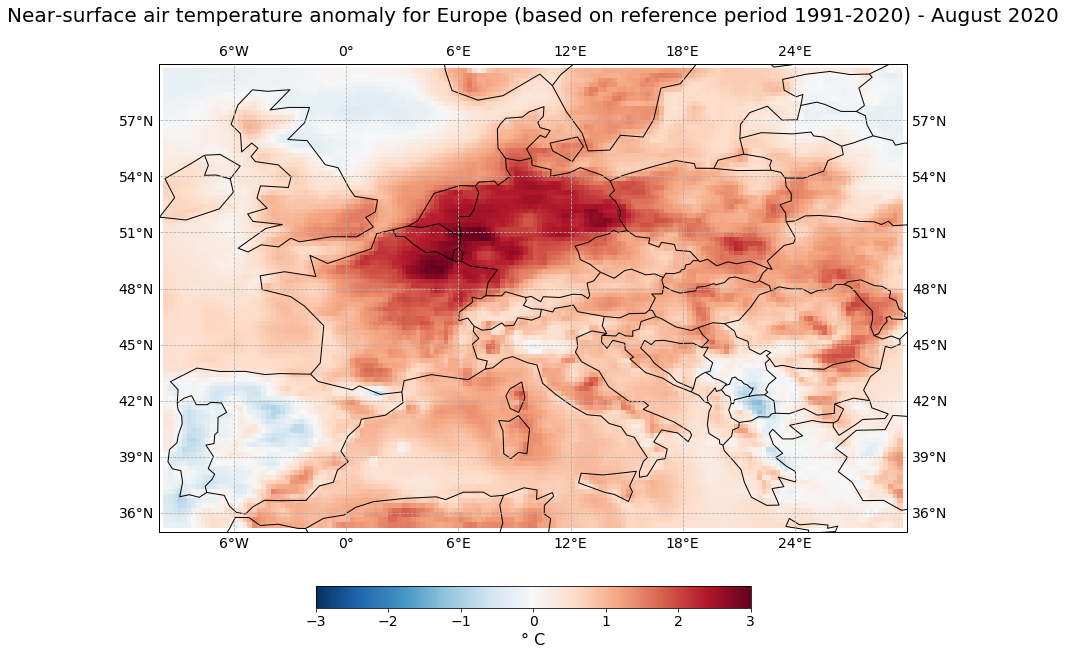

In [109]:
visualize_pcolormesh(data_array = era5_t2m_eur_anomalies_aug[41,:,:],
                    longitude = era5_t2m_eur_anomalies_aug.longitude,
                    latitude = era5_t2m_eur_anomalies_aug.latitude,
                    projection = ccrs.PlateCarree(),
                    color_scale = 'RdBu_r',
                    unit = era5_t2m_eur_anomalies_aug.units,
                    long_name = era5_t2m_eur_anomalies_aug.long_name + ' - August 2020'  '\n',
                    vmin = -3,
                    vmax = 3,
                    set_global=False,
                    latmin=latmin,
                    latmax=latmax,
                    lonmin=lonmin,
                    lonmax=lonmax)

<br>

Next, we would like to also have a look at the time series of the air temperature anomalies for a specific month in Europe. For this, we need to aggregate the geographical field and create the `average` anomaly value across the `latitude` and `longitude` dimensions. You can do this by applying the function `mean()` to both dimensions, `latitude` and `longitude` respectively.

The result is a data array with one dimension (`time`), which has 42 entries. Each entry reflects the average air temperature anomaly in Europe for on year, from 1979 to 2020.

In [115]:
era5_t2m_eur_anomalies_aug_agg = era5_t2m_eur_anomalies_aug.mean(['latitude','longitude'])
era5_t2m_eur_anomalies_aug_agg

<xarray.DataArray 't2m' (time: 42)>
array([-1.7900552 , -1.2267015 , -1.3738687 , -0.83916324, -0.8240493 ,
       -1.2299404 , -1.1444144 , -1.3115491 , -1.5872078 , -0.78060305,
       -0.6609613 , -0.3469016 , -0.23006304,  0.32935423, -1.3037705 ,
        0.147347  , -0.11340991, -0.7037422 ,  0.31962436, -0.73648095,
       -0.23256883, -0.26690066,  0.180784  , -0.05846545,  1.3460804 ,
        0.02515284, -0.96567386, -0.65818   , -0.35998753, -0.14910787,
        0.21562679,  0.060057  , -0.26852173,  0.509669  ,  0.22621895,
       -0.6179058 ,  0.7073681 , -0.10803548,  0.3178205 ,  0.9245312 ,
        0.6759087 ,  0.78727067], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1979-08-01 1980-08-01 ... 2020-08-01
    month    (time) int64 8 8 8 8 8 8 8 8 8 8 8 8 8 ... 8 8 8 8 8 8 8 8 8 8 8 8

<br>

Let us convert the one-dimensional data array above into a `pandas.DataFrame()`. This allows us to handle time-series information more effectively. You can use the xarray function `to_dataframe()`, which converts a `xarray.DataArray` object into a `pandas.DataFrame` object.

Additionally, you want to add a column called `positive`, which indicates with a boolean value whether the temperature anomaly is positive or negative. You also might want to adjust the format of the `index` and only keep the year information.

In [135]:
df_eur_aug = era5_t2m_eur_anomalies_aug_agg.to_dataframe()
df_eur_aug['positive'] = df_eur_aug['t2m'] > 0
df_eur_aug.index = df_eur_aug.index.year

df_eur_aug

,month,t2m,positive
time,,,
1979,8,-1.790055,False
1980,8,-1.226701,False
1981,8,-1.373869,False
1982,8,-0.839163,False
1983,8,-0.824049,False
1984,8,-1.229940,False
1985,8,-1.144414,False
1986,8,-1.311549,False
1987,8,-1.587208,False


<br>

The last step is to visualize the time-series of the European near-surface air temperature anomalies for August (relative to the reference period 1991 to 2020). You can do this by using the built-in `plot()` function for pandas dataframes.  You can customize the plot with the following keyword arguments:
* `figsize`: Define the size of the plot
* `kind`: Type of plot, e.g. `line`, `bar`, etc.
* `color`: color of the bars. With `df.positive.map()`, the colum `positive` is used to distinguish between bars that shall be colored in blue and bars that shall be colored in red
* `fontsize`: fontsize for x- and yticks
* `xlabel`, `ylabel`: Labels for x and y axes
* `title`: Title of the plot

See [here](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.html) a full list of possible keyword arguments.

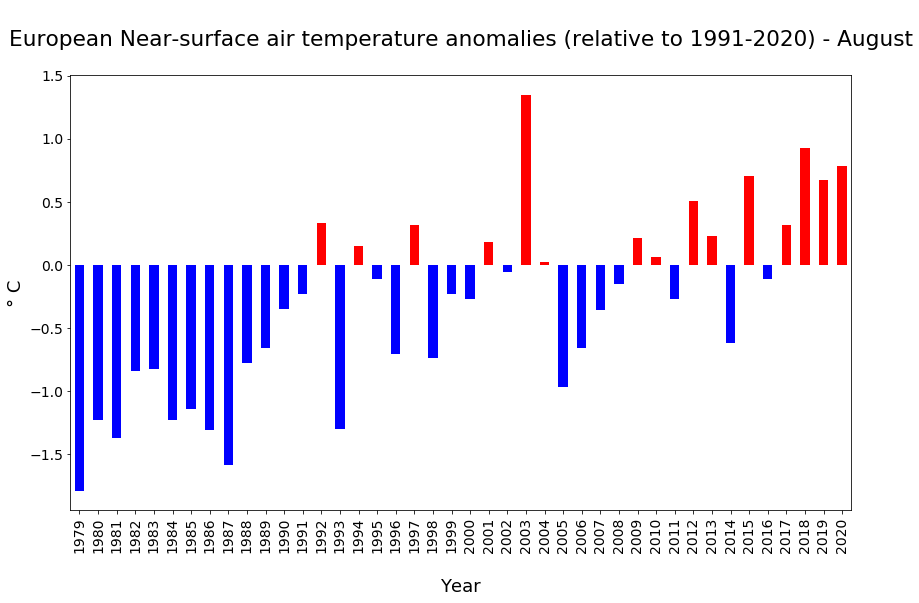

In [134]:
plt.rcParams.update({'font.size': 18}) # must set in top
df_eur_aug['t2m'].plot(
    figsize=(14,8),
    kind='bar',
    color=df_eur_aug.positive.map({True: 'red', False: 'blue'}),
    fontsize=14,
    xlabel='\nYear',
    ylabel='° C',
    title='\nEuropean near-surface air temperature anomalies (relative to 1991-2020) - August\n',
    )

<br>

For one specific month and a specific sub-region, you see in the plot above more variety than compared to the global annual air temperature anomalies. A warming trend is observable, but to a lesser extent, also due to the fact that this time we used 1991 to 2020 as reference period. August 2003 is peculiar as a strong deviation from the long-term mean.

<br>

## <a id='seasonal_arctic'></a>4. Calculation of seasonal variations of near-surface air temperature over the Arctic

The third example focuses on analysing seasonal variations of near-surface air temperature over the Arctic.

**Note:** The example starts with the loaded data array `era5_t2m_da_degc`, which has been prepared under [1. Data preparation](#data_preparation). If you have not loaded the data array object, please go to the first step and follow the step-by-step guide there.

As a reminder, let us have a look at the data array `era5_t2m_da_degc`. You see below that the data array has three dimensions (`time`, `latitude` and `longitude`) and represents the global monthly averaged near-surface air temperature in degrees Celsius from January 1979 to December 2020.

In [10]:
era5_t2m_da_degc

<xarray.DataArray 't2m' (time: 504, latitude: 721, longitude: 1440)>
array([[[-28.442856 , -28.442856 , -28.442856 , ..., -28.442856 ,
         -28.442856 , -28.442856 ],
        [-28.737305 , -28.739075 , -28.739075 , ..., -28.737305 ,
         -28.737305 , -28.737305 ],
        [-28.813126 , -28.813126 , -28.81488  , ..., -28.811356 ,
         -28.811356 , -28.811356 ],
        ...,
        [-31.001251 , -30.997726 , -30.994202 , ..., -31.01007  ,
         -31.006546 , -31.004776 ],
        [-30.581604 , -30.57985  , -30.57808  , ..., -30.586899 ,
         -30.585144 , -30.583374 ],
        [-30.221924 , -30.221924 , -30.221924 , ..., -30.221924 ,
         -30.221924 , -30.221924 ]],

       [[-31.703003 , -31.703003 , -31.703003 , ..., -31.703003 ,
         -31.703003 , -31.703003 ],
        [-32.027435 , -32.02919  , -32.02919  , ..., -32.027435 ,
         -32.027435 , -32.027435 ],
        [-32.18788  , -32.18965  , -32.18965  , ..., -32.186127 ,
         -32.186127 , -32.18788  ],
...
        [-32.894928 , -32.891403 , -32.88611  , ..., -32.907272 ,
         -32.903748 , -32.900208 ],
        [-32.390656 , -32.38713  , -32.38536  , ..., -32.397705 ,
         -32.395935 , -32.39241  ],
        [-32.082092 , -32.082092 , -32.082092 , ..., -32.082092 ,
         -32.082092 , -32.082092 ]],

       [[-20.817017 , -20.817017 , -20.817017 , ..., -20.817017 ,
         -20.817017 , -20.817017 ],
        [-20.859344 , -20.8611   , -20.86287  , ..., -20.85405  ,
         -20.857574 , -20.859344 ],
        [-20.922806 , -20.926346 , -20.92987  , ..., -20.914001 ,
         -20.917526 , -20.921051 ],
        ...,
        [-26.563278 , -26.559753 , -26.554474 , ..., -26.577393 ,
         -26.573868 , -26.568573 ],
        [-26.018448 , -26.016693 , -26.014923 , ..., -26.027267 ,
         -26.021988 , -26.020218 ],
        [-25.695786 , -25.695786 , -25.695786 , ..., -25.695786 ,
         -25.695786 , -25.695786 ]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2020-12-01

<br>

### Create geographical subset for the Arctic region

The first step is to create a geographical subset for the Arctic. You can apply the xarray function `where()` and select all grid points above a latitude of 66.55. The latitude dimension in the resulting data array `era5_t2m_arctic` has decresed to 94 grid points.

In [11]:
era5_t2m_arctic = era5_t2m_da_degc.where(era5_t2m_da_degc.latitude >= 66.55, drop=True)
era5_t2m_arctic

<xarray.DataArray 't2m' (time: 504, latitude: 94, longitude: 1440)>
array([[[-28.442856 , -28.442856 , -28.442856 , ..., -28.442856 ,
         -28.442856 , -28.442856 ],
        [-28.737305 , -28.739075 , -28.739075 , ..., -28.737305 ,
         -28.737305 , -28.737305 ],
        [-28.813126 , -28.813126 , -28.81488  , ..., -28.811356 ,
         -28.811356 , -28.811356 ],
        ...,
        [-18.170456 , -18.26567  , -18.142242 , ..., -18.165176 ,
         -18.061142 , -18.09288  ],
        [-16.315582 , -16.587097 , -16.869232 , ..., -16.216827 ,
         -16.095184 , -16.209778 ],
        [-16.765198 , -17.008514 , -17.251831 , ..., -16.581818 ,
         -16.592407 , -16.678802 ]],

       [[-31.703003 , -31.703003 , -31.703003 , ..., -31.703003 ,
         -31.703003 , -31.703003 ],
        [-32.027435 , -32.02919  , -32.02919  , ..., -32.027435 ,
         -32.027435 , -32.027435 ],
        [-32.18788  , -32.18965  , -32.18965  , ..., -32.186127 ,
         -32.186127 , -32.18788  ],
...
        [-10.243134 ,  -9.828766 ,  -9.098816 , ..., -11.0877075,
         -10.705078 , -10.393005 ],
        [ -8.806122 ,  -8.728546 ,  -8.576904 , ...,  -9.104095 ,
          -8.876648 ,  -8.857239 ],
        [ -9.007111 ,  -9.139374 ,  -9.273376 , ...,  -9.5043335,
          -9.276886 ,  -9.141113 ]],

       [[-20.817017 , -20.817017 , -20.817017 , ..., -20.817017 ,
         -20.817017 , -20.817017 ],
        [-20.859344 , -20.8611   , -20.86287  , ..., -20.85405  ,
         -20.857574 , -20.859344 ],
        [-20.922806 , -20.926346 , -20.92987  , ..., -20.914001 ,
         -20.917526 , -20.921051 ],
        ...,
        [-19.425858 , -19.522827 , -19.420563 , ..., -19.316544 ,
         -19.208984 , -19.327118 ],
        [-18.077011 , -18.394394 , -18.66063  , ..., -18.203964 ,
         -17.944778 , -18.022354 ],
        [-18.501938 , -18.969193 , -19.438202 , ..., -18.711761 ,
         -18.5372   , -18.519577 ]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... 67.25 67.0 66.75
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2020-12-01

<br>

### Calculate the average near-surface air temperature for each season and year

The next step is to calculate for each year and season the average temperature. First, we have to create the average air temperature value for each month across the Arctic. You can do this by applying the function `mean()` across both dimensions, `latitude` and `longitude` respectively.

In [34]:
arctic_mean = era5_t2m_arctic.mean(['latitude', 'longitude'])
arctic_mean

<xarray.DataArray 't2m' (time: 504)>
array([-25.122047  , -29.749844  , -24.14933   , -18.637186  ,
        -7.729572  ,  -0.05636952,   2.4230409 ,   1.1589719 ,
        -3.849453  , -12.512325  , -20.11637   , -23.286375  ,
       -23.539967  , -23.081972  , -21.227997  , -17.3097    ,
        -6.3255568 ,   0.41858563,   2.1483796 ,   0.8215626 ,
        -5.131761  , -11.637004  , -22.791138  , -25.043213  ,
       -23.662811  , -23.326307  , -22.65769   , -15.775268  ,
        -6.7059817 ,   0.67747635,   2.158581  ,   1.2060302 ,
        -4.247083  , -11.24992   , -17.772509  , -22.44797   ,
       -25.738558  , -24.670698  , -22.780495  , -18.120607  ,
        -8.224396  ,   0.2331395 ,   2.4254935 ,   1.094885  ,
        -4.122931  , -12.255336  , -20.210068  , -22.763607  ,
       -24.65753   , -24.336851  , -20.383293  , -17.621553  ,
        -7.413638  ,   0.13264966,   2.335143  ,   1.2645044 ,
        -4.631485  , -13.296301  , -20.867203  , -23.762896  ,
       -23.621124  , -24.51376   , -24.078808  , -18.727186  ,
        -7.5792985 ,   0.675329  ,   2.7937815 ,   1.1731571 ,
        -3.3325663 , -10.493722  , -18.17331   , -20.546076  ,
       -22.63304   , -24.876818  , -23.43651   , -17.770483  ,
        -7.0532017 ,   0.91487634,   2.341613  ,   0.94884163,
...
        -3.0728648 ,  -9.927687  , -17.820587  , -20.976797  ,
       -22.957165  , -23.024372  , -19.59984   , -13.567193  ,
        -7.0559907 ,   1.295465  ,   2.910291  ,   1.5809296 ,
        -3.2738476 ,  -9.795969  , -17.335308  , -23.034914  ,
       -19.757273  , -20.66932   , -19.768877  , -14.386169  ,
        -4.9536276 ,   1.559679  ,   3.3425684 ,   2.0273662 ,
        -1.7559482 ,  -7.3772483 , -12.6115465 , -19.11629   ,
       -21.209631  , -22.207914  , -19.826069  , -14.772941  ,
        -6.961825  ,   0.8763337 ,   2.7067554 ,   1.8038448 ,
        -2.4483843 ,  -9.160286  , -16.279642  , -19.066113  ,
       -21.695768  , -18.684816  , -22.838703  , -15.285883  ,
        -5.780387  ,   1.0962005 ,   2.565222  ,   2.132314  ,
        -2.2607002 ,  -7.084438  , -17.115515  , -20.67683   ,
       -25.01944   , -23.534027  , -21.292896  , -14.018706  ,
        -4.712816  ,   1.6979003 ,   3.0268884 ,   2.3948674 ,
        -1.6866896 ,  -8.365948  , -16.596556  , -21.224579  ,
       -23.728672  , -23.467787  , -22.6041    , -13.208131  ,
        -4.741046  ,   1.8006828 ,   3.379143  ,   2.6810262 ,
        -1.5269406 ,  -7.380356  , -13.11148   , -20.252132  ],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2020-12-01

<br>

In a second step, we can then downsample the monthly averages to seasonal averages. You can do this with the function `resample()`. By specifying `time='QS-DEC'`, the data is split into consecutive three-month periods, anchored at December. If we add additionally the function `mean()`, we calculate the average of the three-month period.

In [55]:
era5_t2m_arctic_seasonal_average = arctic_mean.resample(time='QS-DEC').mean()
era5_t2m_arctic_seasonal_average

<xarray.DataArray 't2m' (time: 169)>
array([-27.435946  , -16.838696  ,   1.1752144 , -12.159383  ,
       -23.30277   , -14.954418  ,   1.1295092 , -13.186634  ,
       -24.010778  , -15.046313  ,   1.3473625 , -11.089837  ,
       -24.285742  , -16.375166  ,   1.2511727 , -12.196111  ,
       -23.919329  , -15.139495  ,   1.244099  , -12.9316635 ,
       -23.965927  , -16.795097  ,   1.5474225 , -10.6665325 ,
       -22.68531   , -16.086731  ,   1.4017769 , -12.017403  ,
       -24.431091  , -16.225168  ,   1.1637783 , -12.327797  ,
       -24.609528  , -16.389803  ,   1.349585  , -14.101092  ,
       -24.688446  , -15.879941  ,   1.604847  , -13.233106  ,
       -24.767677  , -15.512199  ,   1.4975901 , -13.00724   ,
       -22.70194   , -12.707802  ,   1.8719603 , -12.731763  ,
       -24.23786   , -15.651653  ,   1.7244812 , -11.422498  ,
       -24.077097  , -14.989686  ,   0.95195407, -13.138664  ,
       -25.161377  , -16.076553  ,   1.5774235 , -12.779308  ,
       -25.68846   , -16.127966  ,   1.4269094 , -13.03062   ,
       -24.14116   , -14.292331  ,   1.6451181 , -10.999947  ,
       -24.365417  , -14.980705  ,   0.98103166, -11.32408   ,
       -25.215424  , -14.361636  ,   1.1797717 , -11.122022  ,
       -25.614576  , -15.252528  ,   1.8321118 , -11.177628  ,
...
       -23.652128  , -15.071794  ,   1.8029503 , -10.225253  ,
       -23.708618  , -15.426299  ,   1.6896915 , -10.439101  ,
       -24.455782  , -15.214593  ,   1.610037  , -11.610942  ,
       -21.542206  , -14.600312  ,   1.8093983 , -10.444634  ,
       -21.415552  , -14.097653  ,   1.5971268 , -10.0383005 ,
       -22.815674  , -13.964583  ,   2.0024831 ,  -9.378543  ,
       -22.331146  , -14.3810005 ,   1.7374505 , -10.336148  ,
       -21.963923  , -15.176032  ,   1.7420195 ,  -9.593944  ,
       -22.63587   , -13.244794  ,   1.9832587 , -10.236901  ,
       -22.464592  , -13.255802  ,   2.0608537 , -10.172469  ,
       -20.699335  , -13.805316  ,   2.3310986 ,  -9.048434  ,
       -22.92234   , -14.395507  ,   1.6630281 , -10.730388  ,
       -21.23886   , -13.448818  ,   1.7703996 , -10.273713  ,
       -22.319443  , -13.407676  ,   1.9288954 , -10.135041  ,
       -21.153835  , -13.036224  ,   2.3098712 ,  -7.2482476 ,
       -20.844612  , -13.853612  ,   1.7956446 ,  -9.296104  ,
       -19.815565  , -14.634992  ,   1.9312454 ,  -8.820218  ,
       -23.076767  , -13.341474  ,   2.3732188 ,  -8.883064  ,
       -22.807013  , -13.517758  ,   2.620284  ,  -7.339592  ,
       -20.252132  ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1978-12-01 1979-03-01 ... 2020-12-01

<br>

In a last step before visualising the seasonal average air temperature data for the Arctic, we create for each season (`winter`, `spring`, `summer` and `autumn`) a `pandas.DataFrame`.

In [58]:
winter = era5_t2m_arctic_seasonal_average[0::4].to_dataframe()
spring = era5_t2m_arctic_seasonal_average[1::4].to_dataframe()
summer = era5_t2m_arctic_seasonal_average[2::4].to_dataframe()
autumn = era5_t2m_arctic_seasonal_average[3::4].to_dataframe()

winter

,t2m
time,
1978-12-01,-27.435946
1979-12-01,-23.302771
1980-12-01,-24.010778
1981-12-01,-24.285742
1982-12-01,-23.919329
1983-12-01,-23.965927
1984-12-01,-22.685310
1985-12-01,-24.431091
1986-12-01,-24.609528


<br>

The last step is to visualize all four dataframes as time-series plots. The code below creates a matplotlib plot, with a time-series line graph for each season. Each line has a different color: `winter=blue`, `autumn=yellow`, `summer=red` and `spring=green`.

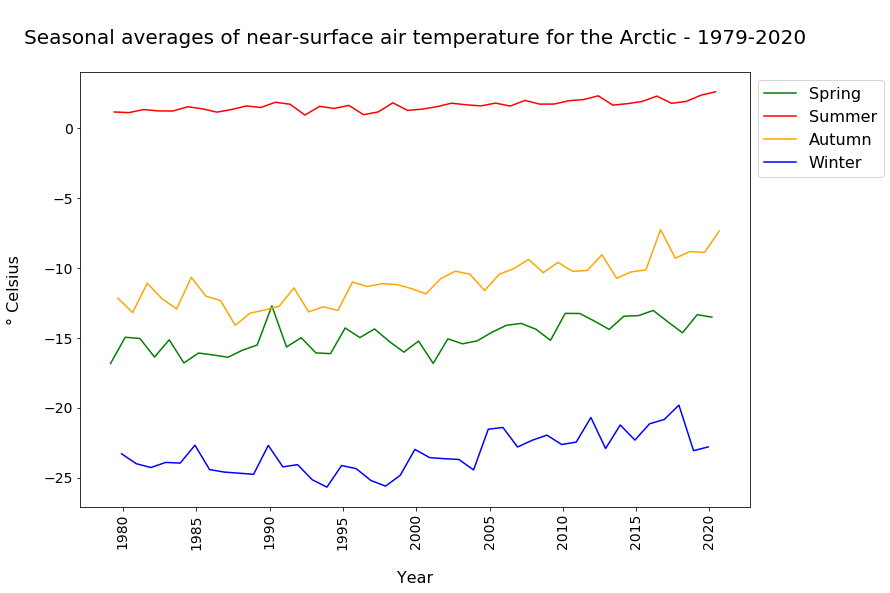

In [71]:
# Initiate the plot
fig = plt.figure(figsize=(12,8))
ax = plt.subplot()

# Create four line plots and specify different colors and lables
ax.plot(spring.t2m, color='green', label='Spring')
ax.plot(summer.t2m, color='red', label='Summer')
ax.plot(autumn.t2m, color='orange', label='Autumn')
ax.plot(winter[1:-1], color='blue', label='Winter')

# Set plot title and axes labels
ax.set_title('\nSeasonal averages of near-surface air temperature for the Arctic - 1979-2020\n', fontsize=20)
ax.set_ylabel('° Celsius\n', fontsize=16)
ax.set_xlabel('\nYear', fontsize=16)

# Increase fontsize of axes tickes
plt.xticks(fontsize=14, rotation=90)
plt.yticks(fontsize=14)

# Add legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, bbox_to_anchor=(1, 1), loc='upper left', fontsize=16)

Note the difference in variability of the seasonal average of air temperature in the Arctic mean: mean summer temperatures seem to be more constant compared to the other seasons.

<hr>

<p><img src='./img/copernicus_logo.png' align='right' alt='Logo EU Copernicus' width='20%'></img></p>
<br><br><br><br><br>
<span style='float:right'><p style=\"text-align:right;\">This project is licensed under <a href="./LICENSE">APACHE License 2.0</a>. | <a href=\"https://github.com/ecmwf-projects/copernicus-training">View on GitHub</a></span>